## Getting all the libraries

In [ ]:
!pip install transformers rouge_score evaluate datasets accelerate>=0.20.3

In [ ]:
from datasets import load_dataset
import requests
import torch
from PIL import Image
from tqdm import tqdm
import numpy as np

device = "cuda" if torch.cuda.is_available() else "cpu"

## Instatiating the Models

In [ ]:
from transformers import GPT2TokenizerFast, VisionEncoderDecoderModel, ViTImageProcessor
Encoder = "google/vit-base-patch16-224"
# Decoder = "bert-base-uncased"
Decoder = "gpt2"

# tokenizer = BertTokenizerFast.from_pretrained(Decoder)
tokenizer = GPT2TokenizerFast.from_pretrained(Decoder)

image_processor = ViTImageProcessor.from_pretrained(Encoder)
model = VisionEncoderDecoderModel.from_encoder_decoder_pretrained(
    Encoder, Decoder
).to(device)

tokenizer.pad_token = tokenizer.eos_token
model.config.eos_token_id = tokenizer.eos_token_id
model.config.pad_token_id = tokenizer.pad_token_id
model.config.decoder_start_token_id = tokenizer.bos_token_id

## Image Preprocessing

In [6]:
from torch.utils.data import Dataset, DataLoader
from PIL import Image
import os
import pandas as pd

class Image_handle_datastructure(Dataset):
    def __init__(self, df, image_folder, tokenizer, image_processor, device, max_length):
        self.df = df
        self.image_folder = image_folder
        self.tokenizer = tokenizer
        self.image_processor = image_processor
        self.device = device
        self.max_length = max_length

    def preprocess(self, items):
        pixel_values = self.image_processor(items["image"], return_tensors="pt").pixel_values.to(self.device)

        targets = self.tokenizer(
            items["caption"],
            max_length=self.max_length,
            padding="max_length",
            truncation=True,
            return_tensors="pt"
        ).to(self.device)

        return {'pixel_values': pixel_values, 'labels': targets["input_ids"]}


    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        path = os.path.join(self.image_folder, self.df.iloc[idx]['filename'])
        image = Image.open(path).convert("RGB")
        caption = self.df.iloc[idx]['caption']
        return self.preprocess({'image': image, 'caption': caption})


## Removing invalid images

In [7]:
import os
import pandas as pd
max_length = 75
batch_size = 16

folder_train = "/kaggle/input/dataset-dl/custom_captions_dataset/train"
folder_test = "/kaggle/input/dataset-dl/custom_captions_dataset/test/"
folder_validation = "/kaggle/input/dataset-dl/custom_captions_dataset/val/"

csv_train = "/kaggle/input/dataset-dl/custom_captions_dataset/train.csv"
csv_test = "/kaggle/input/dataset-dl/custom_captions_dataset/test.csv"
csv_val = "/kaggle/input/dataset-dl/custom_captions_dataset/val.csv"

# preprocessing the dataset, removing all Images that are invalid(less than 3 dimensions) or caption field is empty
folders = [folder_train,folder_test,folder_validation]
caption_files = [csv_train,csv_test,csv_val]
invalid_images=[]
dataframes = [pd.read_csv(caption_files[i]) for i in range(3)]

for i in range(3):
    for filename in os.listdir(folders[i]):
        image = Image.open(os.path.join(folders[i],filename))
        if np.array(image).ndim not in [3,4]:
            invalid_images.append(filename)

    df = dataframes[i]
    df = df[~df['filename'].isin(invalid_images)]
    df.dropna(inplace=True)
    invalid_images = []

/tmp/ipykernel_34/3346075933.py:28: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.dropna(inplace=True)


In [8]:
len(dataframes[0])

5715

## Code for model evaluation, BLEU and ROUGE scores

In [9]:
import evaluate

bleu = evaluate.load("bleu")
rouge=evaluate.load("rouge")

def compute_metrics(eval_pred):
    predictions = eval_pred.label_ids
    labels = eval_pred.predictions

    pred_str = tokenizer.batch_decode(predictions, skip_special_tokens=True)
    labels_str = tokenizer.batch_decode(labels, skip_special_tokens=True)

    # compute the Bleu score
    bleu_score = bleu.compute(predictions=pred_str, references=labels_str)

    # compute rouge score
    rouge_result = rouge.compute(predictions=pred_str, references=labels_str)
    rouge_result = {k: round(v * 100, 4) for k, v in rouge_result.items()}

    generation_length = bleu_score["translation_length"]

    return {
        **rouge_result,
        "bleu": round(bleu_score["bleu"] * 100, 4),

    }


## Making the dataloaders

In [13]:

dataset_train = Image_handle_datastructure(
    df=dataframes[0],
    image_folder=folder_train,
    tokenizer=tokenizer,
    image_processor=image_processor,
    device=device,
    max_length=max_length
)

In [14]:
dataset_val = Image_handle_datastructure(
    df=dataframes[2],
    image_folder=folder_validation,
    tokenizer=tokenizer,
    image_processor=image_processor,
    device=device,
    max_length=max_length
)

In [ ]:
dataset_test = Image_handle_datastructure(
    df=dataframes[1],
    image_folder=folder_test,
    tokenizer=tokenizer,
    image_processor=image_processor,
    device=device,
    max_length=max_length
)

## Garbage Collection

In [16]:
import gc

torch.cuda.empty_cache()

gc.collect()

48

## Collating the data and making the dataloaders

In [18]:
def collate_fn(batch):
    return {
        'pixel_values': torch.stack([x['pixel_values'][0] for x in batch]),
        'labels': torch.stack([x['labels'][0] for x in batch])
    }

# This function takes a batch of preprocessed examples and stacks the pixel values and labels into tensors. It will be used by the data loader to collate the samples into batches.

In [19]:
from torch.utils.data import DataLoader

dataset_train_loader = DataLoader(dataset_train, batch_size=batch_size, collate_fn=collate_fn, shuffle=True)
dataset_test_loader = DataLoader(dataset_test, batch_size=batch_size, collate_fn=collate_fn, shuffle=False)
dataset_val_loader = DataLoader(dataset_val, batch_size=batch_size, collate_fn=collate_fn, shuffle=False)

## Optimizer

In [20]:
from torch.optim import AdamW

optimizer = AdamW(model.parameters(), lr=1e-5)

In [21]:
import evaluate

bleu = evaluate.load("bleu")
rouge=evaluate.load("rouge")

def compute_metrics(eval_pred):
    predictions = eval_pred.label_ids
    labels = eval_pred.predictions

    # Decode the predictions and labels
    pred_str = tokenizer.batch_decode(predictions, skip_special_tokens=True)
    labels_str = tokenizer.batch_decode(labels, skip_special_tokens=True)

    # Compute the Bleu score
    bleu_score = bleu.compute(predictions=pred_str, references=labels_str)

    #compute rouge score
    rouge_result = rouge.compute(predictions=pred_str, references=labels_str)
    rouge_result = {k: round(v * 100, 4) for k, v in rouge_result.items()}

    # Get the length of the generated captions
    generation_length = bleu_score["translation_length"]

    return {
        **rouge_result,
        "bleu": round(bleu_score["bleu"] * 100, 4),

    }


In [22]:
n_train_steps = len(dataset_train_loader)
n_valid_steps = len(dataset_val_loader)
current_step = 0
save_steps = 100


## Training the model along with the evaluation on the validation set

In [24]:
from transformers import EvalPrediction
num_epochs = 10
batch_size = 16

for epoch in range(num_epochs):
    model.train()

    train_loss, valid_loss = 0, 0
    print()
    print("epoch ", epoch," training phase ")

    for batch in tqdm(dataset_train_loader, "Training", total=len(dataset_train_loader), leave=False):

        pixel_values = batch["pixel_values"]
        labels = batch["labels"]

        outputs = model(pixel_values=pixel_values, labels=labels)

        loss = outputs.loss

        loss.backward()

        optimizer.step()

        optimizer.zero_grad()

        loss_value = loss.item()
        train_loss += loss_value

    print()
    print(f"Validation......")
    print()

    model.eval()

    predictions, labels = [], []

    valid_loss = 0

    i = 0
    for batch in dataset_val_loader:
        i = i+1
        pixel_values = batch["pixel_values"]
        label_ids = batch["labels"]

        outputs = model(pixel_values=pixel_values, labels=label_ids)

        loss = outputs.loss
        valid_loss += loss.item()

        logits = outputs.logits.detach().cpu()

        predictions.extend(logits.argmax(dim=-1).tolist())

        labels.extend(label_ids.tolist())

    eval_prediction = EvalPrediction(predictions=predictions, label_ids=labels)

    metrics = compute_metrics(eval_prediction)

    print()
    print(f"Epoch : {epoch+1}")
    print(f"Training  Loss: {train_loss / n_train_steps:.4f} ")
    print(f"Validation Loss: {valid_loss / n_valid_steps:.4f} ")
    print(f"BLEU SCORE: {metrics['bleu']:.4f}, ")
    print(f"Rouge-L Score: {metrics['rougeL']:.4f}")


epoch  0  training phase 



Validation......


Epoch : 0
Training  Loss: 2.1397 
Validation Loss: 2.0742 
BLEU SCORE: 17.2063, 
Rouge-L Score: 45.0746

epoch  1  training phase 



Validation......


Epoch : 1
Training  Loss: 2.0519 
Validation Loss: 2.0357 
BLEU SCORE: 17.8006, 
Rouge-L Score: 45.6692

epoch  2  training phase 



Validation......


Epoch : 2
Training  Loss: 1.9916 
Validation Loss: 2.0140 
BLEU SCORE: 18.1214, 
Rouge-L Score: 46.1238

epoch  3  training phase 



Validation......


Epoch : 3
Training  Loss: 1.9399 
Validation Loss: 1.9979 
BLEU SCORE: 18.4829, 
Rouge-L Score: 46.5449

epoch  4  training phase 



Validation......


Epoch : 4
Training  Loss: 1.8908 
Validation Loss: 1.9889 
BLEU SCORE: 18.6174, 
Rouge-L Score: 46.7292

epoch  5  training phase 



Validation......


Epoch : 5
Training  Loss: 1.8442 
Validation Loss: 1.9871 
BLEU SCORE: 18.5686, 
Rouge-L Score: 46.7627

epoch  6  training phase 



Validation......


Epoch : 6
Training  Loss: 1.7982 
Validation Loss: 1.9884 
BLEU SCORE: 18.5703, 
Rouge-L Score: 46.9200

epoch  7  training phase 



Validation......


Epoch : 7
Training  Loss: 1.7539 
Validation Loss: 1.9958 
BLEU SCORE: 18.3789, 
Rouge-L Score: 46.8768

epoch  8  training phase 



Validation......


Epoch : 8
Training  Loss: 1.7098 
Validation Loss: 2.0043 
BLEU SCORE: 18.1973, 
Rouge-L Score: 46.8649

epoch  9  training phase 



Validation......


Epoch : 9
Training  Loss: 1.6640 
Validation Loss: 2.0208 
BLEU SCORE: 17.9331, 
Rouge-L Score: 46.7258


## Test Inferencing and Scoring

In [26]:
from transformers import EvalPrediction

test_loss = 0
predictions, labels = [], []
for batch in tqdm(dataset_test_loader, "Testing", total=len(dataset_test_loader), leave=False):
        pixel_values = batch["pixel_values"]
        label_ids = batch["labels"]

        outputs = model(pixel_values=pixel_values, labels=label_ids)

        loss = outputs.loss
        test_loss += loss.item()

        logits = outputs.logits.detach().cpu()

        predictions.extend(logits.argmax(dim=-1).tolist())

        labels.extend(label_ids.tolist())

test_prediction = EvalPrediction(predictions=predictions, label_ids=labels)
metrics = compute_metrics(test_prediction)
print(f"Test Loss: {test_loss / n_valid_steps:.4f} ")
print(f"Test BLEU SCORE: {metrics['bleu']:.4f}, ")
print(f"Test Rouge-L Score: {metrics['rougeL']:.4f}")

Test Loss: 1.9507 
Test BLEU SCORE: 17.4988, 
Test Rouge-L Score: 46.2731


## Printing 10 images with their captions

The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.



0 .   test_1.jpg
Caption from the datset:  A large building with bars on the windows in front of it. There is people walking in front of the building. There is a street in front of the building with many cars on it. 


/opt/conda/lib/python3.10/site-packages/transformers/generation/utils.py:1132: UserWarning: Using the model-agnostic default `max_length` (=20) to control the generation length. We recommend setting `max_new_tokens` to control the maximum length of the generation.
  warnings.warn(


Caption Generated by the model :  A large white building with a large white building on the side is on the corner of a street


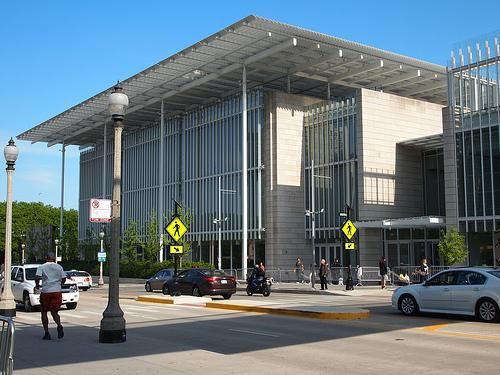


1 .   test_2.jpg
Caption from the datset:  A person is skiing through the snow. There is loose snow all around them from him jumping. The person is wearing a yellow snow suit. The person is holding two ski poles in their hands. 


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Caption Generated by the model :  A man is skiing down a hill. He is wearing a black jacket and black pants. He


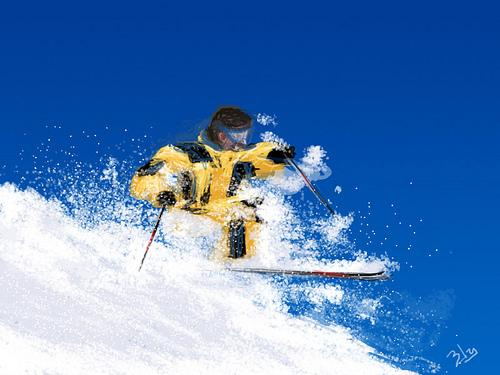

The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.



2 .   test_3.jpg
Caption from the datset:  There is a bed in a room against a wall. There is a brown blanket on top of the bed. There is a small brown book shelf next to the bed. There is a picture hanging on the wall above the shelf. 
Caption Generated by the model :  A white bed is in a room with a white wall. There is a white pillow on the


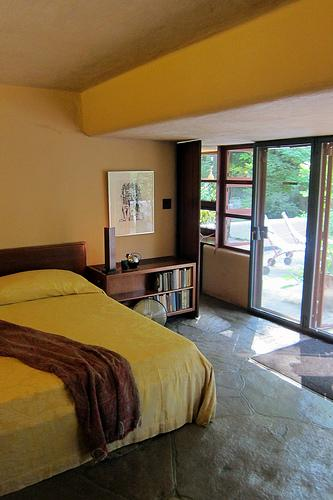

The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.



3 .   test_4.jpg
Caption from the datset:  A black and red train is on the tracks and has steam coming out off of it. There is another train next to the first train that is orange. There is an overpass over the train tracks with cars on it. 
Caption Generated by the model :  A train is on the tracks. The train is red and white. The train has a yellow


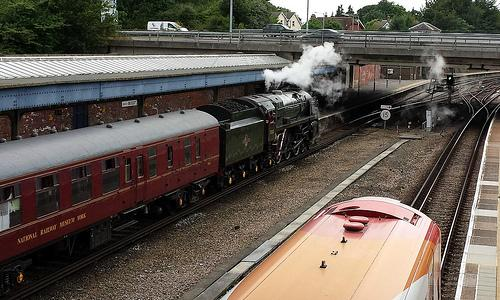

The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.



4 .   test_5.jpg
Caption from the datset:  A white and yellow public transportation bus with "122" on front is stopped with it's doors open. There is a gray car on the street beside the bus. Behind the car there is a  building with an "Urban Outfitters" on the first floor.
Caption Generated by the model :  A bus is driving down a street. The bus is white and has a blue and red sign


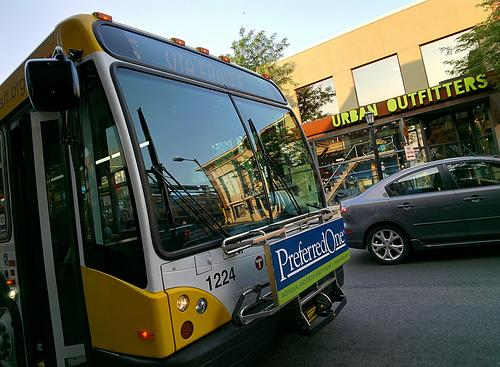

The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.



5 .   test_6.jpg
Caption from the datset:  A large white house with a brown door sits behind some grass. There are four sheep grazing on the grass in front of the house. The house ahs a gray roof. 
Caption Generated by the model :  A white and black dog is standing on a grassy field.  The dog has a black


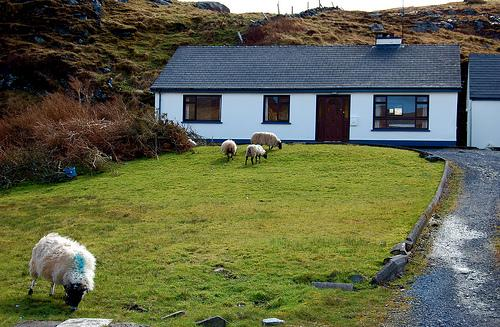

The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.



6 .   test_7.jpg
Caption from the datset:  A man in a red and yellow t-shirt is holding a Wii remote in each of his hands. Behind him there is a fireplace which has been painted white. In front of him a light which is on and illuminating the room. 
Caption Generated by the model :  A man is sitting in a chair. He is wearing a black shirt and gray pants. He


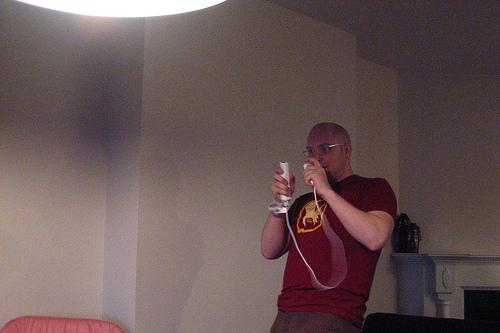

The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.



7 .   test_8.jpg
Caption from the datset:  There are three men riding bicycles. Two of the men are wearing yellow and the third man has a blue shirt. The two men are way ahead of the third man. The men are bicycling in the bicycle lane. The cars are on the left side of the men.
Caption Generated by the model :  A person is riding a bike on a sidewalk. The person is wearing a black jacket and blue


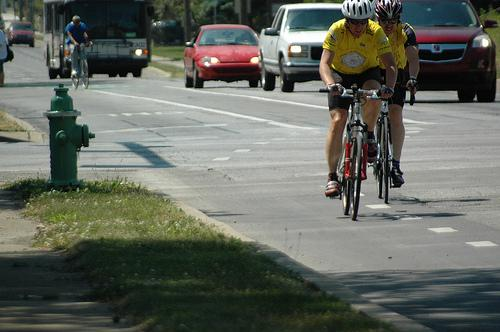

The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.



8 .   test_9.jpg
Caption from the datset:  TWO CELL PHONES ON THE TABLE.THEY BOTH ARE DARK IN COLOR A ND ARE BLACBERRYS.THERE ARE THREE CUTTING KNIVES.ONE KNIFE IS BETWEEN THE TWO PHONES.THERE IS A THIRD PHONE WITH A KNIFE LYING OVER IT.
Caption Generated by the model :  A black and white photo of a black and white pistol. The pistol is black and white.


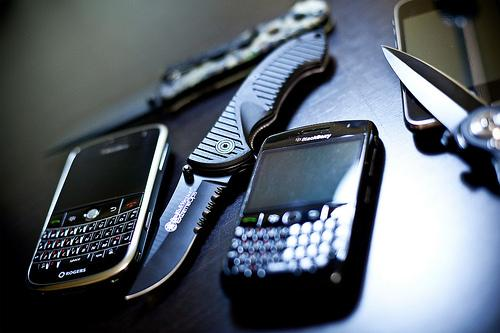

The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.



9 .   test_10.jpg
Caption from the datset:  A painted mannequin head sits on a table. It is a feminine head with arched eyebrows a small nose, big eyes and it is wearing a black top hat and a brown wig. To the right of the head is a metal sculpture clock with a white face.
Caption Generated by the model :  A man is standing in front of a clock. The clock is white and has a gold face


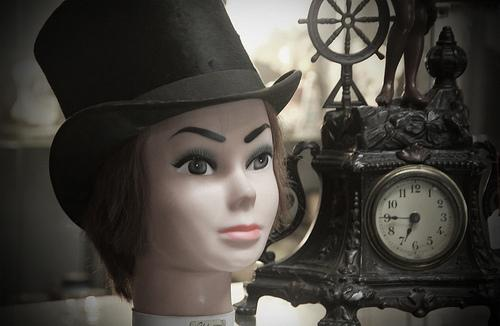

The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.



10 .   test_11.jpg
Caption from the datset:  A white and yellow train is on the tracks. There is a large yellow door on the front of the train. There is a platform next to the train. 
Caption Generated by the model :  A train is on the tracks. The train is yellow and blue. The train is on the


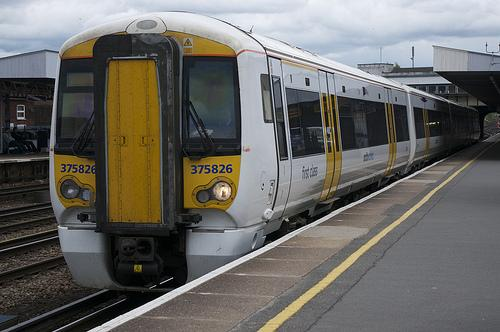

In [27]:
test = dataframes[1]
test = test.reset_index() 

for idx, row in test.iterrows():
    if(0 <= idx and idx <= 10):
      path = row["filename"]
      caption = row["caption"]
      print()
      print(idx,".  ",path)
      print("Caption from the datset: ",caption)
      path = os.path.join(folder_test,path)
      image = Image.open(path).convert("RGB")
      img = image_processor(image, return_tensors="pt").to(device)
      # generate the caption (using greedy decoding by default)
      output = model.generate(**img)
      # decode the output
      caption = tokenizer.batch_decode(output, skip_special_tokens=True)[0]
      print("Caption Generated by the model : ",caption)

      display(image)